# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [21]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [22]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';') 

In [23]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#Check the structure of azdias dataframe
print(azdias.shape)
print(azdias.head())

#Check the structure of feat info dataframe
print(feat_info.shape)
print(feat_info.head())

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [24]:
# Convert the attribute and missing_or_unknown columns to dictionary 
feat_dict = feat_info[["attribute", "missing_or_unknown"]].to_dict("records")

#Loop through dictionary to convert values for the missing_or_unknown from str to list format
for i in feat_dict:
    i['missing_or_unknown'] = i['missing_or_unknown'].strip("][").split(",")
    try:
        # Convert items in the list to integer
        i['missing_or_unknown'] = [int(x) for x in i['missing_or_unknown']]
    except ValueError:
        # Ignore strings like X, XX
        continue
feat_dict

[{'attribute': 'AGER_TYP', 'missing_or_unknown': [-1, 0]},
 {'attribute': 'ALTERSKATEGORIE_GROB', 'missing_or_unknown': [-1, 0, 9]},
 {'attribute': 'ANREDE_KZ', 'missing_or_unknown': [-1, 0]},
 {'attribute': 'CJT_GESAMTTYP', 'missing_or_unknown': [0]},
 {'attribute': 'FINANZ_MINIMALIST', 'missing_or_unknown': [-1]},
 {'attribute': 'FINANZ_SPARER', 'missing_or_unknown': [-1]},
 {'attribute': 'FINANZ_VORSORGER', 'missing_or_unknown': [-1]},
 {'attribute': 'FINANZ_ANLEGER', 'missing_or_unknown': [-1]},
 {'attribute': 'FINANZ_UNAUFFAELLIGER', 'missing_or_unknown': [-1]},
 {'attribute': 'FINANZ_HAUSBAUER', 'missing_or_unknown': [-1]},
 {'attribute': 'FINANZTYP', 'missing_or_unknown': [-1]},
 {'attribute': 'GEBURTSJAHR', 'missing_or_unknown': [0]},
 {'attribute': 'GFK_URLAUBERTYP', 'missing_or_unknown': ['']},
 {'attribute': 'GREEN_AVANTGARDE', 'missing_or_unknown': ['']},
 {'attribute': 'HEALTH_TYP', 'missing_or_unknown': [-1, 0]},
 {'attribute': 'LP_LEBENSPHASE_FEIN', 'missing_or_unknown':

In [25]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(azdias.shape[1]):
    azdias[azdias.columns[i]].replace(feat_dict[i]['missing_or_unknown'], np.nan, inplace=True)


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [26]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_vals = (azdias.isna().sum()/azdias.shape[0])*100
null_vals.sort_values()

ZABEOTYP                  0.000000
SEMIO_TRADV               0.000000
SEMIO_PFLICHT             0.000000
SEMIO_KAEM                0.000000
SEMIO_DOM                 0.000000
SEMIO_KRIT                0.000000
SEMIO_RAT                 0.000000
SEMIO_KULT                0.000000
SEMIO_ERL                 0.000000
SEMIO_LUST                0.000000
SEMIO_VERT                0.000000
SEMIO_MAT                 0.000000
SEMIO_REL                 0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
FINANZ_VORSORGER          0.000000
ANREDE_KZ                 0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
GREEN_AVANTGARDE          0.000000
FINANZTYP                 0.000000
ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET   

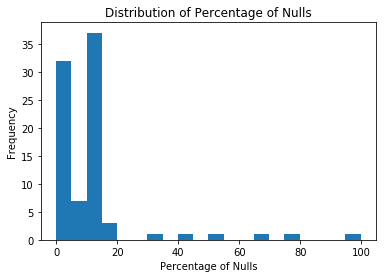

In [27]:
# Investigate patterns in the amount of missing data in each column.
#View the distribution of percentage of null values
plt.hist(null_vals, bins=20)
plt.xlabel("Percentage of Nulls")
plt.ylabel("Frequency")
plt.title("Distribution of Percentage of Nulls")
plt.show()

In [28]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Drop all columns whose percentage of nulls is more than 25%
azdias.drop(azdias.columns[null_vals > 25], axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column
The chart above clearly shows that the distribution of null values is right skewed. Most of the points have a percentage of nulls less than 25%. Thus, columns that have a percentage greater than 25% were dropped. 
(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
null_vals_row = (azdias.isna().sum(axis=1)/azdias.shape[1]) * 100
null_vals_row.value_counts()

0.000000     623209
59.493671     45578
2.531646      27926
54.430380     27369
10.126582     24592
6.329114      22515
3.797468      17629
1.265823      15738
7.594937      13771
8.860759      13714
5.063291      12607
43.037975     10816
12.658228      5410
18.987342      4743
44.303797      3911
16.455696      3255
11.392405      3042
41.772152      2985
20.253165      2505
17.721519      2243
24.050633      1180
13.924051      1127
15.189873       766
21.518987       677
46.835443       538
56.962025       494
22.784810       428
48.101266       421
51.898734       356
25.316456       349
40.506329       206
55.696203       155
26.582278       150
50.632911       137
29.113924       132
27.848101       129
45.569620        84
49.367089        77
30.379747        69
32.911392        59
31.645570        55
34.177215        24
53.164557        21
36.708861        12
37.974684         6
35.443038         5
39.240506         3
62.025316         2
60.759494         1
dtype: int64

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Considering a cut-off of 20%
azdias_large_null = azdias.loc[null_vals_row > 20]
azdias_small_null = azdias.loc[null_vals_row <= 20]

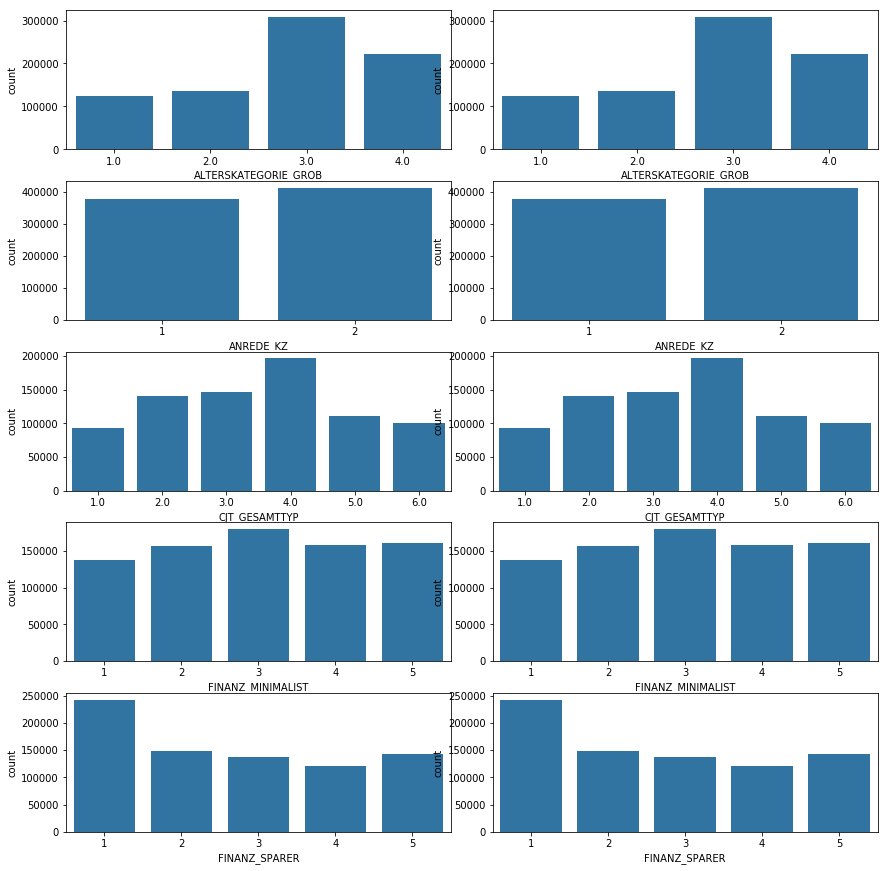

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12,12))
fig.tight_layout()
cols_l = azdias_large_null.columns[:5]
cols_s = azdias_small_null.columns[:5]
default_color = sns.color_palette()[0]
for i in range(len(cols_l)):
    for j in range(2):
        if j == 0:
            sns.countplot(data=azdias_large_null, x=cols_l[i], ax=ax[i,j], color=default_color) 
        sns.countplot(data=azdias_small_null, x=cols_s[i], ax=ax[i,j], color=default_color)
plt.show()
#sns.countplot(data=azdias_large_null, x=azdias_large_null.columns[:5])

#### Discussion 1.1.3: Assess Missing Data in Each Row
A look at the charts above shows that there is no significant difference, qualitatively, between the no or few missing fata subset and lots of missing data subset.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

##Drop the rows from feat_info that correspond to the dropped columns in azdias
rows = ["ALTER_HH", "GEBURTSJAHR", "KBA05_BAUMAX","KK_KUNDENTYP","AGER_TYP","TITEL_KZ"]
idx = feat_info.index[(feat_info.attribute == rows[0]) | (feat_info.attribute == rows[1]) | (feat_info.attribute == rows[2]) | (feat_info.attribute == rows[3])
                      | (feat_info.attribute == rows[4]) | (feat_info.attribute == rows[5])].tolist()
feat_info_update = feat_info.drop(idx, axis=0)

##Create a list of columns that has type categorical
cols = feat_info_update[feat_info_update.type == "categorical"]["attribute"]
for col in cols:
    print(azdias_small_null[col].value_counts())


2    413088
1    379199
Name: ANREDE_KZ, dtype: int64
4.0    196762
3.0    146095
2.0    140765
5.0    110562
6.0    101053
1.0     92682
Name: CJT_GESAMTTYP, dtype: int64
6    288550
1    195593
5    105764
2    103866
4     55652
3     42862
Name: FINANZTYP, dtype: int64
12.0    128616
10.0    102367
8.0      82677
11.0     74638
5.0      70334
4.0      60383
9.0      56655
3.0      53062
1.0      50549
2.0      42465
7.0      40496
6.0      25677
Name: GFK_URLAUBERTYP, dtype: int64
0    618002
1    174285
Name: GREEN_AVANTGARDE, dtype: int64
1.0     399976
10.0    128403
2.0      97756
11.0     48595
8.0      21675
7.0      19406
4.0      11505
5.0      11128
9.0      10401
6.0       8333
3.0       4598
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    399976
5.0    187399
2.0     97756
4.0     49414
3.0     27231
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206219
9.0     134865
10.0    111059
2.0     110710
4.0      73792
3.0      68750
6.0      28679
5.0      27130
8.0      17558
7.0    

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode the values in OST_WEST_KZ column to 0 and 1
bin_dict = {"W":0, "O":1}
azdias_small_null["OST_WEST_KZ"].replace(bin_dict, inplace=True)
#List of binary columns that need dummies
columns=["OST_WEST_KZ","ANREDE_KZ", "GREEN_AVANTGARDE", "VERS_TYP","SOHO_KZ"]

#List of multi level categorical columns to be dropped 
drop_columns = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP',
                'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
                'ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']

#Drop multi level categorical columns
azdias_small_null.drop(drop_columns, axis=1, inplace=True)   

# Create dummies for binary columns
azdias_small_null = pd.get_dummies(azdias_small_null, columns=columns)
azdias_small_null.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,OST_WEST_KZ_0,OST_WEST_KZ_1,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_1.0,VERS_TYP_2.0,SOHO_KZ_0.0,SOHO_KZ_1.0
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,1,0,0,1,1,0,0,1,0,1
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,1,0,0,1,0,1,1,0,1,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,1,0,0,1,1,0,1,0,1,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,1,0,1,0,1,0,0,1,1,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,1,0,0,1,1,0,0,1,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features
The dataset has 49 ordinal, 21 categorical, 7 mixed, 7 numeric  and 1 interval columns. Out of the 21 categorical columns, 5 are binary. Hence, using pandas.get_dummies, they were encoded as 0 and 1. Note that one of the columns was in non-numerical format so it was first converted to numerals before it was givem dummies. For the remaining categorical columns (multi level) they were dropped, as providing dummies for them would have taken large computational space.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create a dictionary using the unique column values as keys and the decade as values 
dicts = {1:40, 2:40, 
             3:50, 4:50, 
             5:60, 6:60, 7:60, 
             8:70, 9:70, 
             10:80, 11:80, 12:80, 13:80, 
             14:90, 15:90}
#map the dictionary unto PRAEGENDE_JUGENDJAHRE column to create a new column 
azdias_small_null["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_small_null["PRAEGENDE_JUGENDJAHRE"].map(dicts)

# Create a dictionary using the unique column values as keys and the movement as values 
dicts = {1:0, 2:1, 
         3:0, 4:1, 
         5:0, 6:1, 7:1, 
         8:0, 9:1, 
         10:0, 11:1,
         12:0, 13:1, 
         14:0, 15:1}
#map the dictionary unto PRAEGENDE_JUGENDJAHRE column to create a new column 
azdias_small_null["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias_small_null["PRAEGENDE_JUGENDJAHRE"].map(dicts)

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create a list of values in CAMEO_INTL_2015 column
lst = azdias_small_null["CAMEO_INTL_2015"].unique().tolist()
lst.remove(np.nan)
lst = [int(i) for i in lst]
#Create a dictionary by looping through list to create a dictionary if it meets any of the conditions
#Condition is according to wealth
dicts = {}
for i in lst:
    if i <= 15:
        dicts[str(i)] = 0
    elif i <= 25:
        dicts[str(i)] = 1
    elif i <= 35:
        dicts[str(i)]  = 2
    elif i <= 45:
        dicts[str(i)] = 3
    elif i <= 55:
        dicts[str(i)] = 4
#map the dictionary unto CAMEO_INTL_2015 column to create a new column 
azdias_small_null["CAMEO_INTL_2015_WEALTH"] = azdias_small_null["CAMEO_INTL_2015"].map(dicts)

#Create a dictionary by looping through list to create a dictionary if it meets any of the conditions
#Condition is according to life stage typology
lst = [str(i) for i in lst]
dicts = {}
for i in lst:
    if i[1] == "1":
        dicts[i] = 0
    elif i[1] == "2":
        dicts[i] = 1
    elif i[1] == "3":
        dicts[i]  = 2
    elif i[1] == "4":
        dicts[i] = 3
    elif i[1] == "5":
        dicts[i] = 4
#map the dictionary unto CAMEO_INTL_2015 column to create a new column 
azdias_small_null["CAMEO_INTL_2015_LIFE_STAGE"] = azdias_small_null["CAMEO_INTL_2015"].map(dicts)

#### Discussion 1.2.2: Engineer Mixed-Type Features
As stated earlier, there are 7 columns that have mixed as its type. For this analysis, only two (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) were considered because of the relative ease with which one is able to engineer new features.The PRAEGENDE_JUGENDJAHRE was engineered to produce two new columns according to decade and movement. The CAMEO_INTL_2015 was engineered to produce two new columns according to wealth and life stage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
cols = (feat_info_update[feat_info_update.type == "mixed"]["attribute"]).tolist()

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_small_null.drop(cols, axis=1, inplace=True)
azdias_small_null.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,VERS_TYP_1.0,VERS_TYP_2.0,SOHO_KZ_0.0,SOHO_KZ_1.0,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,1,0,0,1,0,1,90.0,0.0,4.0,0.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,0,1,1,0,1,0,90.0,1.0,1.0,3.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,1,0,1,0,1,0,70.0,0.0,0.0,1.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,1,0,0,1,1,0,70.0,0.0,3.0,2.0
5,1.0,3,1,5,2,2,5,3.0,3.0,2,...,1,0,0,1,1,0,50.0,0.0,4.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_dict = feat_info[["attribute", "missing_or_unknown"]].to_dict("records")
    for i in feat_dict:
        i['missing_or_unknown'] = i['missing_or_unknown'].strip("][").split(",")
        try:
            i['missing_or_unknown'] = [int(x) for x in i['missing_or_unknown']]
        except ValueError:
            continue
    for i in range(df.shape[1]):
        df[df.columns[i]].replace(feat_dict[i]['missing_or_unknown'], np.nan, inplace=True)

    # remove selected columns and rows, ...
    # Subset data according to the number of rows with nan    
    null_vals_rows = (df.isna().sum(axis=1)/df.shape[1]) * 100
    df = df.loc[null_vals_rows <= 20]
    # select, re-encode, and engineer column values.
    rows = ["ALTER_HH", "GEBURTSJAHR", "KBA05_BAUMAX","KK_KUNDENTYP","AGER_TYP","TITEL_KZ"]
    idx = feat_info.index[(feat_info.attribute == rows[0]) | (feat_info.attribute == rows[1]) | (feat_info.attribute == rows[2]) | (feat_info.attribute == rows[3])
                      | (feat_info.attribute == rows[4]) | (feat_info.attribute == rows[5])].tolist()
    feat_info_update = feat_info.drop(idx, axis=0)
    ## drop columns froms null columns dataframe
    df.drop(rows, axis=1, inplace=True)
    
    #provide binary categorical data with dummies and drop the rest
    bin_dict = {"W":0, "O":1}
    df["OST_WEST_KZ"].replace(bin_dict, inplace=True)
    columns=["OST_WEST_KZ","ANREDE_KZ", "GREEN_AVANTGARDE", "VERS_TYP","SOHO_KZ"]
    drop_columns = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP',
                'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
                'ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    df.drop(drop_columns, axis=1, inplace=True)       
    df = pd.get_dummies(df, columns=columns)
    
    #create a new column from PRAEGENDE_JUGENDJAHRE according to decade
    dicts = {1:40, 2:40, 
             3:50, 4:50, 
             5:60, 6:60, 7:60, 
             8:70, 9:70, 
             10:80, 11:80, 12:80, 13:80, 
             14:90, 15:90}
    df["PRAEGENDE_JUGENDJAHRE_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].map(dicts)
    
    #create a new column from PRAEGENDE_JUGENDJAHRE accordimg to movement
    dicts = {1:0, 2:1, 
         3:0, 4:1, 
         5:0, 6:1, 7:1, 
         8:0, 9:1, 
         10:0, 11:1,
         12:0, 13:1, 
         14:0, 15:1}
    df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].map(dicts)
    
    #create a new column from CAMEO_INTL_2015 according to wealth
    lst = df["CAMEO_INTL_2015"].unique().tolist()
    lst.remove(np.nan)
    lst = [int(i) for i in lst]
    dicts = {}
    for i in lst:
        if i <= 15:
            dicts[str(i)] = 0
        elif i <= 25:
            dicts[str(i)] = 1
        elif i <= 35:
            dicts[str(i)]  = 2
        elif i <= 45:
            dicts[str(i)] = 3
        elif i <= 55:
            dicts[str(i)] = 4

    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].map(dicts)
 
    #create a new column according to life stage typology
    lst = [str(i) for i in lst]
    dicts = {}
    for i in lst:
        if i[1] == "1":
            dicts[i] = 0
        elif i[1] == "2":
            dicts[i] = 1
        elif i[1] == "3":
            dicts[i]  = 2
        elif i[1] == "4":
            dicts[i] = 3
        elif i[1] == "5":
            dicts[i] = 4
    df["CAMEO_INTL_2015_LIFE_STAGE"] = df["CAMEO_INTL_2015"].map(dicts)
    
    #drop all columns with mixed type
    cols = (feat_info_update[feat_info_update.type == "mixed"]["attribute"]).tolist()
    df.drop(cols, axis=1, inplace=True)
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df = azdias_small_null.copy()
impute = Imputer()
X_imp = impute.fit_transform(df)

In [41]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
X_sca = scaler.fit_transform(X_imp)

### Discussion 2.1: Apply Feature Scaling
When it comes to treating missing values, a basic strategy is to remove all missing values. However, for this dataset, the number of rows that will be dropped will be too large, thus the need to apply an Imputer to replace all missing values. K-means clustering is "isotropic" (produces clusters that are more or less circular rather than elongated) in all directions of space. In other words, leaving unequal variances is comparable to giving variables with lower variance greater weight. Therefore, standardization, which is giving the dataset a mean of 0 and standard deviation of 1, will help reduce this effect


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(X_sca)

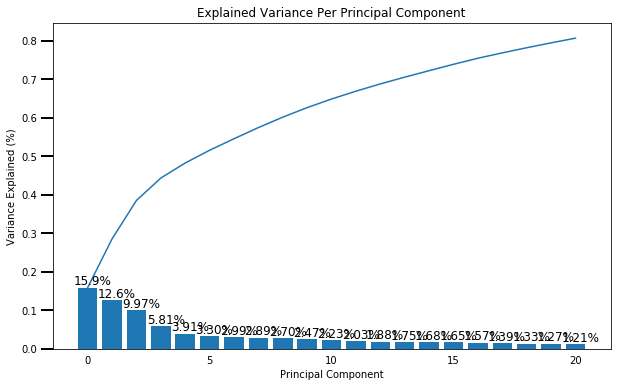

In [43]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = 21
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[:num_components]
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [44]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=21)
X = pca.fit_transform(X_sca)

### Discussion 2.2: Perform Dimensionality Reduction
An Initial PCA was applied without specifying the number of components. Thus, a scre plot was plotted which showed that about 21 number of components explain up to 80% of the variation, which is a fair cutoff mark. Thus, the PCA was re-applied using the number of components as 21, dropping the rest.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def comp(n):
    """Input: principal component
    Output: sorted dataframe containing features and their corresponding weights
    """
    df1 = pd.DataFrame({"features":df.columns.tolist(), "weights":pca.components_[n]})
    return df1.sort_values("weights")
comp(0)

,features,weights
42,MOBI_REGIO,-0.241937
32,KBA05_ANTG1,-0.226635
46,PLZ8_ANTG1,-0.225221
1,FINANZ_MINIMALIST,-0.217268
36,KBA05_GBZ,-0.217018
51,PLZ8_GBZ,-0.168422
30,KONSUMNAEHE,-0.164310
39,INNENSTADT,-0.160539
68,CAMEO_INTL_2015_LIFE_STAGE,-0.124000
37,BALLRAUM,-0.122752


In [46]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp(1)

,features,weights
11,SEMIO_REL,-0.261859
16,SEMIO_KULT,-0.243853
65,PRAEGENDE_JUGENDJAHRE_DECADE,-0.239973
2,FINANZ_SPARER,-0.226456
22,SEMIO_TRADV,-0.221879
21,SEMIO_PFLICHT,-0.219673
5,FINANZ_UNAUFFAELLIGER,-0.217035
10,SEMIO_FAM,-0.210192
4,FINANZ_ANLEGER,-0.183083
12,SEMIO_MAT,-0.169512


In [47]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp(3)

,features,weights
59,GREEN_AVANTGARDE_0,-0.390339
41,KKK,-0.223453
37,BALLRAUM,-0.209912
39,INNENSTADT,-0.200685
25,HH_EINKOMMEN_SCORE,-0.200570
44,REGIOTYP,-0.163066
30,KONSUMNAEHE,-0.145179
56,OST_WEST_KZ_1,-0.128646
4,FINANZ_ANLEGER,-0.102368
40,GEBAEUDETYP_RASTER,-0.083184


### Discussion 2.3: Interpret Principal Components
For this analysis, a correlation of 0.2 or more is deemed important.
> First Principal Component Analysis: The first principal component is well, positively correlated with four of the original features. PLZ8_ANTG4, PLZ8_ANTG3, CAMEO_INTL_2015_WEALTH, HH_EINKOMMEN_SCORE which stands for Number of 10+ family houses in the PLZ8 region, Number of 6-10 family houses in the PLZ8 region, Wealth Status of HouseHolds, and Estimated household net income respectively. It is negatively correlated with MOBI_REGIO, KBA05_ANTG1, PLZ8_ANTG1, FINANZ_MINIMALIST, KBA05_GBZ. These represent  Movement patterns, Number of 1-2 family houses in the microcell, Number of 1-2 family houses in the PLZ8 region, Financial typology (low financial interest), and Number of buildings in the microcell respectively. 
This implies that the first principal component increases with an increase in the size, or income/wealth status of the household and decreases with an increase in number/size of the houses as well as movement patterns and financial typology. It is a measure of the house and household.

> 2nd Principal Component Analysis: The second principal component is positively correlated with ALTERSKATEGORIE_GROB, SEMIO_ERL, and FINANZ_VORSORGER. These represents Estimated age based on given name analysis, Personality typology  (event oriented) and Financial typology (be prepared). It is negatively correlated with SEMIO_PFLICHT, SEMIO_TRADV, SEMIO_FAM, SEMIO_REL, SEMIO_KULT, PRAEGENDE_JUGENDJAHRE_DECADE, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER
They represent personality type for dutiful, traditional minded, family minded, religious, and cultural minded, Dominating movement of person's youth according to decade and Financial typology for money saver and inconspicuous respectively. This component is a measure of mainly the personality and financial type of the individual. 

> 3rd Principal Component Analysis: The third principal component is positively correlated to GREEN_AVANTGARDE_1, PRAEGENDE_JUGENDJAHRE_MOVEMENT, EWDICHTE, and ORTSGR_KLS9. They represent Membership in environmental sustainability as part of youth (Member), Dominating movement of person's youth (avantgarde vs. mainstream), Density of households per square kilometer, Size of community respectively. It is negatively correlated to GREEN_AVANTGARDE_0, KKK,
BALLRAUM, HH_EINKOMMEN_SCORE, and INNENSTADT.
This represent Membership in environmental sustainability as part of youth (Non-Member), Purchasing power in region, Distance to nearest urban center, Estimated household net income, and Distance to city center (downtown). Thus, this a measure of the activities of the person’s youth, size/income of the community and distance to the city center.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
inertia_score =[]
avg_score = []
k_clusters = list(range(1,11))
for k in k_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42) 
    model = kmeans.fit(X)
    
    # compute the average within-cluster distances.
    inertia_score.append(model.inertia_)
    avg_score.append(model.score(X))

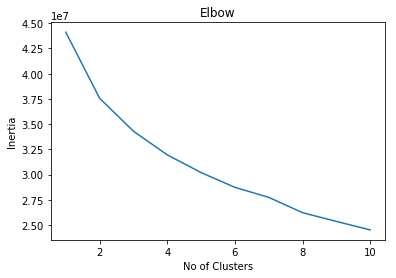

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(k_clusters, inertia_score)
plt.xlabel("No of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow")
plt.show()

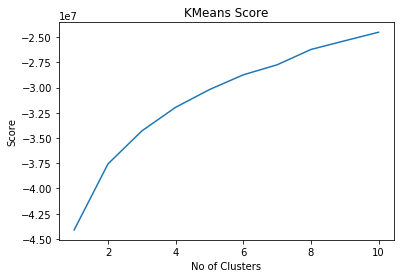

In [65]:
plt.plot(k_clusters, avg_score)
plt.xlabel("No of Clusters")
plt.ylabel("Score")
plt.title("KMeans Score")
plt.show()

In [48]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9, random_state=42) 
model = kmeans.fit(X)
label = model.predict(X)

### Discussion 3.1: Apply Clustering to General Population
For this dataset, KMeans clustering was used. Firstly, a range of components from 1 to 10 was used to fit the data. After which, the inertia and score were calculated to aid in the determining the optimum number of components. This was then plotted as shown in the figure above. It was decided that the optimum number of components is 9, thus, the kmeans model was refitted using 9.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [49]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
customers_clean = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [50]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
X_imp1 = impute.transform(customers_clean)
X_sca1 = scaler.transform(X_imp1)
X_pca1 = pca.transform(X_sca1)
label_cust = model.predict(X_pca1)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

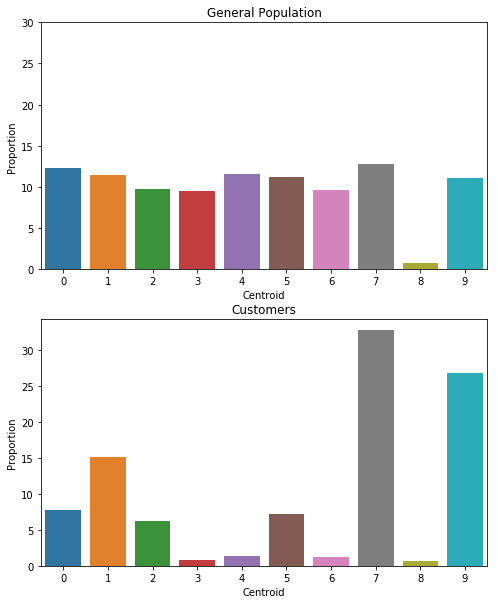

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#Create an array of null values for general population
a = np.array([len(azdias_large_null)]) 

#Append array to existing array of number of data points per cluster centroid for general population
gen_array = np.bincount(label)
gen_array = np.append(gen_array, a)

#Calculate proportion of data points 
gen_prop = (gen_array/azdias.shape[0])*100

#Create an array of null values for customers
l = customers.shape[0] - customers_clean.shape[0]
b = np.array([l])

#Append array to existing array of number of data points per cluster centroid for general population
cus_array = np.bincount(label_cust)
cus_array = np.append(cus_array, b)

#Calculate proportion of data points 
cus_prop = (cus_array/customers.shape[0])*100

#Create barplot of these proportions
x = np.arange(10)
fig, ax = plt.subplots(nrows=2, figsize=(8,10))
for i in range(2):
    ax[i].set_yticks(np.arange(0,35,step=5))
    if i == 0:
        title_ = "General Population"
        y = gen_prop
    else:
        title_ = "Customers"
        y = cus_prop
        
    ax[i].set_title(title_)
    ax[i].set_ylabel("Proportion")
    ax[i].set_xlabel("Centroid")
    sns.barplot(x=x, y=y, ax=ax[i])
    ax[i].set_yticks(np.arange(0,35,step=5))
plt.show()

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Centroid of interest
centroid_8 = kmeans.cluster_centers_[7]

#inverse transform the pca
transformed_pca = pca.inverse_transform(centroid_8)  

#inverse transform scaler
data_8 = scaler.inverse_transform(transformed_pca)

#create pandas series
over_8 = pd.Series(data=data_8, index=df.columns)
over_8.sort_values()

SOHO_KZ_1.0                         -0.000005
GREEN_AVANTGARDE_0                   0.000406
ANZ_TITEL                            0.010787
KBA05_ANTG4                          0.011991
ANZ_HH_TITEL                         0.028070
ANREDE_KZ_1                          0.038094
OST_WEST_KZ_1                        0.099783
KBA05_ANTG3                          0.140225
PLZ8_ANTG4                           0.401877
VERS_TYP_2.0                         0.484050
VERS_TYP_1.0                         0.492454
OST_WEST_KZ_0                        0.900217
ANREDE_KZ_2                          0.961906
GREEN_AVANTGARDE_1                   0.999594
SOHO_KZ_0.0                          1.000005
PRAEGENDE_JUGENDJAHRE_MOVEMENT       1.002127
CAMEO_INTL_2015_WEALTH               1.075543
KBA05_ANTG2                          1.103148
PLZ8_ANTG3                           1.196613
ANZ_HAUSHALTE_AKTIV                  1.651422
FINANZ_SPARER                        1.789375
SEMIO_KULT                        

In [53]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Centroid of interest
centroid_5 = kmeans.cluster_centers_[4]

#inverse transform the pca
transformed_pca = pca.inverse_transform(centroid_5)  

#inverse transform scaler
data_5 = scaler.inverse_transform(transformed_pca)

#create pandas series
under_5 = pd.Series(data=data_5, index=df.columns)
under_5.sort_values()

ANREDE_KZ_2                         -0.058951
SOHO_KZ_1.0                         -0.000025
ANZ_TITEL                            0.002822
ANZ_HH_TITEL                         0.022948
OST_WEST_KZ_1                        0.224401
GREEN_AVANTGARDE_1                   0.230030
PRAEGENDE_JUGENDJAHRE_MOVEMENT       0.237219
KBA05_ANTG4                          0.294821
VERS_TYP_2.0                         0.421330
VERS_TYP_1.0                         0.525055
PLZ8_ANTG4                           0.762796
GREEN_AVANTGARDE_0                   0.769970
OST_WEST_KZ_0                        0.775599
KBA05_ANTG3                          0.801265
SOHO_KZ_0.0                          1.000025
ANREDE_KZ_1                          1.058951
KBA05_ANTG1                          1.291185
KBA05_ANTG2                          1.367433
PLZ8_ANTG3                           1.719616
CAMEO_INTL_2015_LIFE_STAGE           1.720820
ANZ_PERSONEN                         1.726043
ALTERSKATEGORIE_GROB              

### Discussion 3.3: Compare Customer Data to Demographics Data
> MIN_GEBAEUDEJAHR has the most effect. Followed by KBA13_ANZAHL_PKW and PRAEGENDE_JUGENDJAHRE_DECADE. Thus, First year building was mentioned in the database, Number of cars in the PLZ8 region and Dominating movement of person's youth (avantgarde vs. mainstream) has the most popular with the company. 
> Whilst ANREDE_KZ_2, SOHO_KZ_1.0, ANZ_TITEL, and GREEN_AVANTGARDE_0 are the least popular.They represent Gender, Small office / home office, Academic title, and not a member of green avantgarde respectively.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.